In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn
import holidays
from scrape import corona_lockdowns
seaborn.set()

# Load Data

In [13]:
# Load Data and preprocess
df                      = pd.read_excel("data/Realized Schedule.xlsx")  # Load Train and validation data  
df_test                 = pd.read_excel("data/Future Schedule.xlsx")    # Load test data
# y_val                   = df[df.ScheduleTime > train].LoadFactor
# y_train                 = df[df.ScheduleTime <= train].LoadFactor
data                    = pd.concat([df, df_test]).reset_index()
dates                   = data.ScheduleTime.dt.date
coronadays              = [dates[i] in corona_lockdowns[data.iloc[i].Sector] if data.iloc[i].Sector in corona_lockdowns.keys() else False for i in range(len(data))]
data["Hour"]            = data.ScheduleTime.dt.hour
data["Weekday"]         = data.ScheduleTime.dt.weekday
data["US_Holiday"]      = pd.Series(data.ScheduleTime).apply(lambda x: holidays.CountryHoliday('US',prov='NSW').get(x))
data["High_Season"]     = data.ScheduleTime.dt.month.isin([6,7,8])
data['Corona']          = pd.Series(coronadays)
# data = pd.get_dummies(data.drop(["FlightNumber","index"], axis = 1))  # Drop FlightNumber and AircraftType for simplicity

# data_train  = data[data.ScheduleTime <= train].drop(["LoadFactor", "ScheduleTime"], axis = 1)                                                   
# data_val    = data[(data.ScheduleTime > train) * (data.ScheduleTime < '2022-03-01')].drop(["LoadFactor", "ScheduleTime"], axis = 1)  
# data_test   = data[data.ScheduleTime >= '2022-03-01'].drop(["LoadFactor", "ScheduleTime"], axis = 1)  # March for test data

# data_train = data_train.fillna(replacer_mu) # Replace NaN with mean Load Factor in training data


In [23]:
df = pd.get_dummies(data.drop(["index", "FlightNumber"], axis = 1))

df[df.ScheduleTime < '2022-03-01'].to_csv("data/train_data.csv", index=False)
df[df.ScheduleTime >= '2022-03-01'].drop('LoadFactor', axis = 1).to_csv("data/test_data.csv", index=False)

In [22]:
df

,ScheduleTime,SeatCapacity,LoadFactor,Hour,Weekday,High_Season,Corona,Airline_5M,Airline_AP,Airline_AY,...,US_Holiday_Juneteenth National Independence Day,US_Holiday_Juneteenth National Independence Day (Observed),US_Holiday_Labor Day,US_Holiday_Martin Luther King Jr. Day,US_Holiday_Memorial Day,US_Holiday_New Year's Day,US_Holiday_New Year's Day (Observed),US_Holiday_Thanksgiving,US_Holiday_Veterans Day,US_Holiday_Washington's Birthday
0,2021-01-01 06:35:00,142,0.408451,6,4,False,True,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2021-01-01 10:35:00,74,0.189189,10,4,False,True,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2021-01-01 12:05:00,142,0.570423,12,4,False,True,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2021-01-01 13:20:00,72,0.333333,13,4,False,True,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2021-01-01 14:20:00,186,0.204301,14,4,False,True,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44257,2022-03-31 21:05:00,186,NaN,21,3,False,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44258,2022-03-31 20:55:00,230,NaN,20,3,False,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44259,2022-03-31 21:50:00,186,NaN,21,3,False,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44260,2022-03-31 20:30:00,186,NaN,20,3,False,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 0, 'Time (days)')

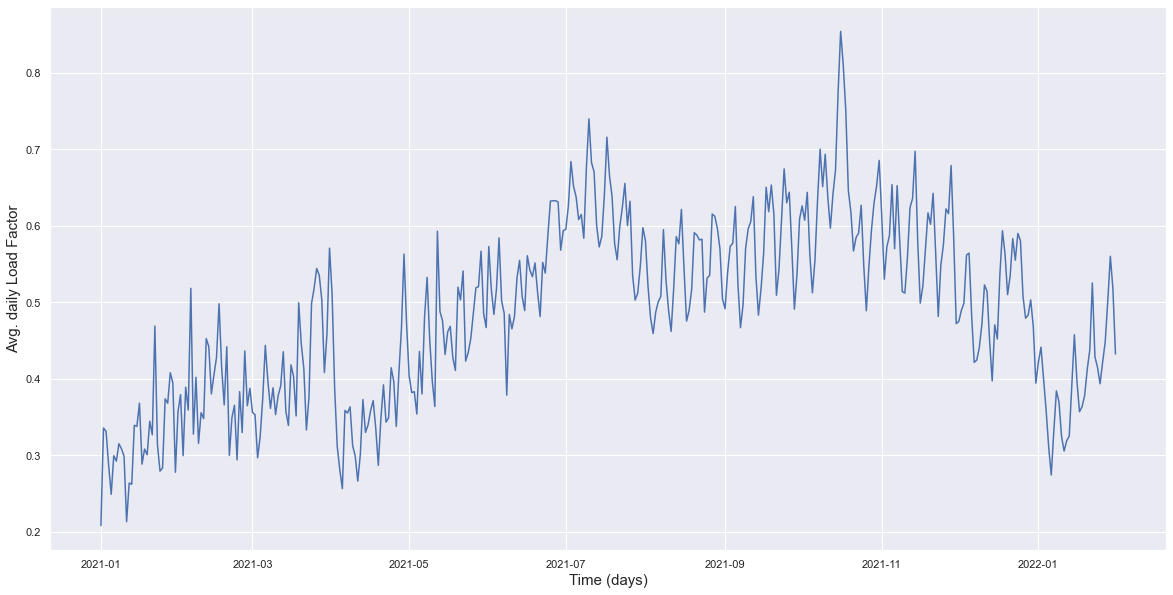

In [5]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(data.set_index('ScheduleTime').LoadFactor.resample('1d').mean())
ax.set_ylabel("Avg. daily Load Factor", fontsize  = 15);
ax.set_xlabel("Time (days)", fontsize = 15)

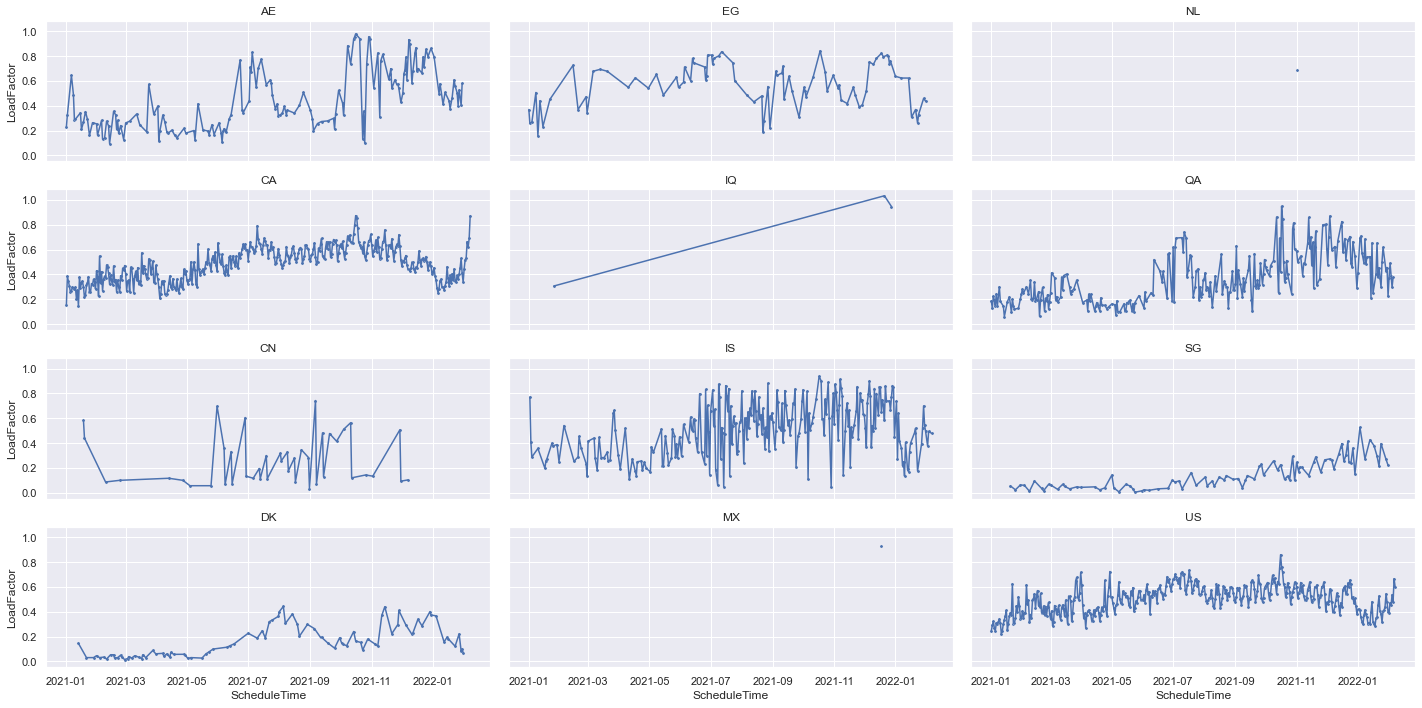

In [31]:
df2 = data.copy()
df2.ScheduleTime = pd.to_datetime(df.ScheduleTime).dt.date
df2
means = df2.groupby(["Sector", "ScheduleTime"]).aggregate({'LoadFactor':'mean'}).reset_index()

dests = means.Sector.unique()

fig, ax = plt.subplots(4,3, figsize = (20,10), sharey = True, sharex=True)

for i in range(len(dests)):
    
    a = ax[i % 4, i // 4]
    seaborn.lineplot(data = means[means.Sector == dests[i]], x = 'ScheduleTime', y = 'LoadFactor', legend = True, ax = a, ls = '-')
    seaborn.scatterplot(data = means[means.Sector == dests[i]], x = 'ScheduleTime', y = 'LoadFactor', legend = True, ax = a, s = 10)
    a.set_title(dests[i])

fig.tight_layout()

# Time - Series Predictions

In [362]:
model1 = RandomForestRegressor().fit(data_train, y_train)

In [363]:
data2 = data_val.copy()
N = len(data2)
preds = np.zeros(N)
for i in tqdm(range(N)):
    x = data2.iloc[i,:]
    sector, destination, airline = x[x==1].index[[-1,-3,-4]]
    predicted_load = model1.predict(x.to_frame().T.fillna(0.3))
    preds[i] = predicted_load
    # Update Data
    if i < N - 1:
        sector_col = data2[sector].iloc[i+1:]
        try:
            # If no futute values belong to this 
            sector_idx = sector_col[sector_col == 1].index[0]
        except:
            pass

        destination_col = data2[destination].iloc[i+1:]
        try:
            destination_idx = destination_col[destination_col == 1].index[0]
        except:
            pass

        airline_col = data2[airline].iloc[i+1:]
        try:
            airline_col_idx = airline_col[airline_col == 1].index[0]
        except:
            pass

        data2.loc[sector_idx, "load_prev_sector"] = predicted_load
        data2.loc[destination_idx, "load_prev_destination"] = predicted_load
        data2.loc[airline_col_idx, "load_prev_airline"] = predicted_load

100%|██████████| 3608/3608 [00:41<00:00, 86.14it/s]


In [364]:
abs(preds-y_val).mean()

0.17940312770535083

In [365]:
model2 = RandomForestRegressor().fit(data_train.drop(["load_prev_destination","load_prev_sector","load_prev_airline"], axis = 1), y_train)

In [372]:
abs(model2.predict(data_val.drop(["load_prev_destination", "load_prev_sector", "load_prev_airline"], axis = 1)) - y_val).mean()

0.16383536436268128

# Without Time series

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished


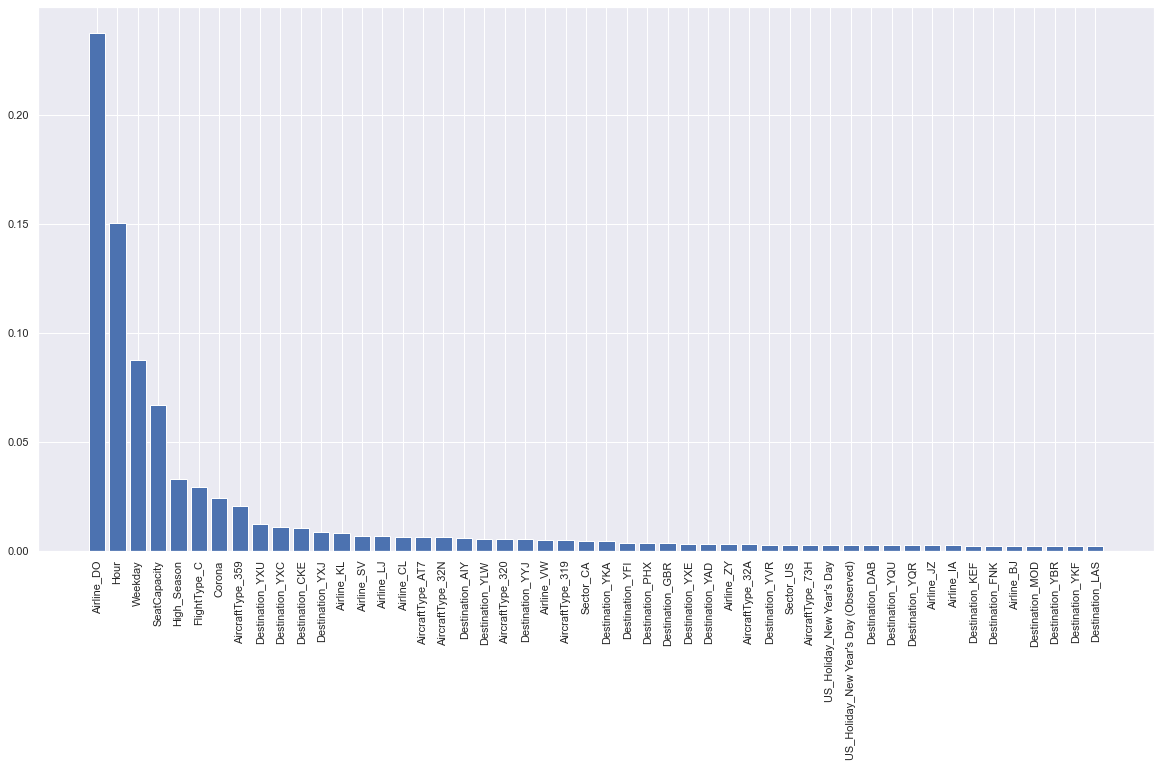

In [42]:
model = RandomForestRegressor(n_estimators=1, verbose = True, n_jobs = -1).fit(data_train, y_train)
idx = model.feature_importances_.argsort()[::-1]

data_train.columns[idx]
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(np.arange(50), model.feature_importances_[idx][:50])
ax.set_xticks(np.arange(50))
ax.set_xticklabels(data_train.columns[idx][:50], rotation = 90);

In [43]:
pow(model.predict(data_val)**2 - y_val, 2).mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


0.11993601716014504

In [44]:
model2 = RandomForestRegressor(n_estimators=50,
                               verbose = True,
                               n_jobs=-1,
                               max_leaf_nodes=250).fit(data_train[data_train.columns[idx][:200]], y_train)

abs(model2.predict(data_val[data_train.columns[idx][:200]]) - y_val).mean()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


0.1583335250571106

In [51]:
from sklearn.inspection import permutation_importance
forest = RandomForestRegressor(n_estimators=50).fit(data_train, y_train)
result = permutation_importance(
    forest, data_train, y_train, n_repeats=5, random_state=42, n_jobs=-1
)

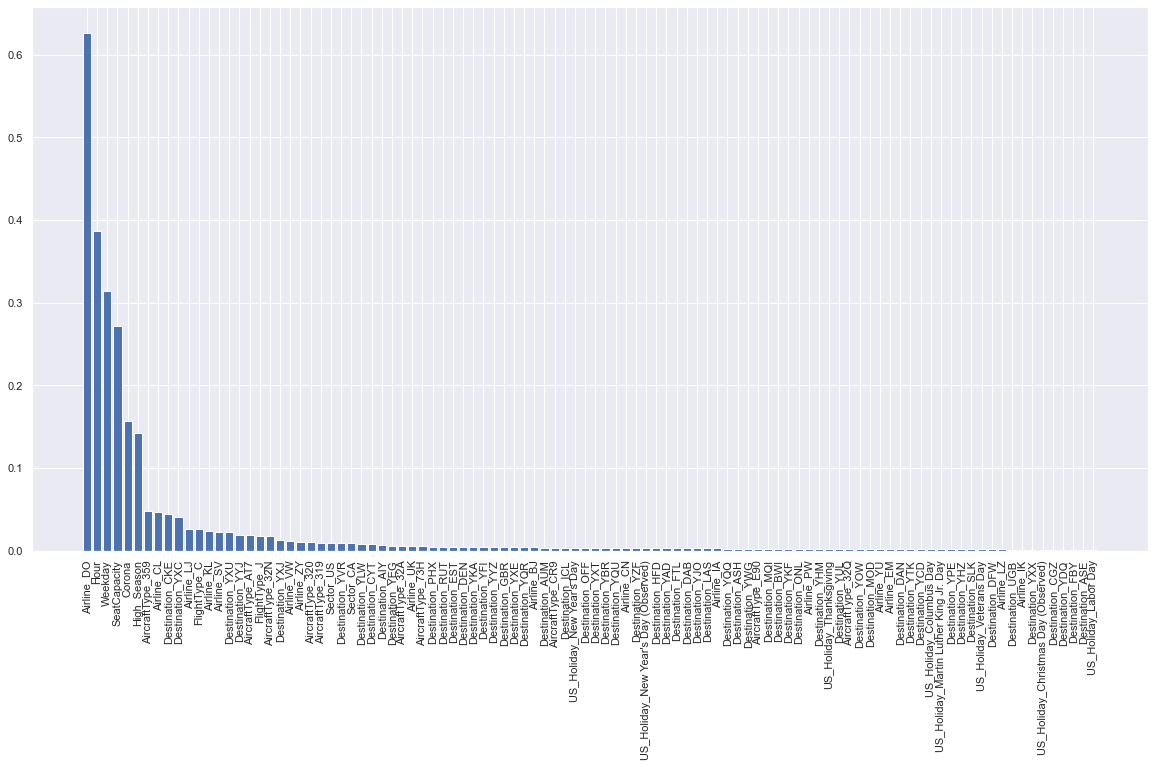

In [52]:
idx2 = result['importances_mean'].argsort()[::-1]

data_train.columns[idx2]
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(np.arange(100),  result['importances_mean'][idx2][:100])
ax.set_xticks(np.arange(100))
ax.set_xticklabels(data_train.columns[idx2][:100], rotation = 90);
np.save("feature_importeance.npy", result)

In [45]:
model3 = RandomForestRegressor(max_leaf_nodes=700, verbose = True, n_jobs=-1, n_estimators = 500, max_features=80).fit(data_train, y_train)

pow(model3.predict(data_val) - y_val,2).mean()


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


0.03580152261180691

In [46]:
np.sqrt(0.042457828689453116), np.sqrt(0.039596112848208), np.sqrt(0.03858508287632304), np.sqrt(0.03580152261180691), np.sqrt(0.037276163113454476)

(0.20605297544430926,
 0.19898772034527157,
 0.19643086029522713,
 0.1892129028681895,
 0.19307035793579105)

In [54]:
model3 = RandomForestRegressor(max_leaf_nodes=800, verbose = True, n_jobs=-1, n_estimators = 500).fit(data_train[data_train.columns[idx2][:100]], y_train)
abs(model3.predict(data_val[data_train.columns[idx2][:100]]) - y_val).mean()
err = pow(model3.predict(data_val[data_train.columns[idx2][:100]]) - y_val, 2).mean()
print(err, np.sqrt(err))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   52.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


0.036101239763791204 0.19000326250828223


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


In [26]:
N  = 200
model3 = AdaBoostRegressor(DecisionTreeRegressor(max_leaf_nodes=700, n_estimators = 500)).fit(data_train[data_train.columns[idx2][:N]],
                                                       y_train)

pow(model3.predict(data_val[data_train.columns[idx2][:N]]) - y_val, 2).mean()

TypeError: __init__() got an unexpected keyword argument 'n_estimators'

In [96]:
pow(y_train.mean() - y_val,2).mean()
np.sqrt(pow(y_train.mean() - y_val,2).mean())

0.27859457506102453

In [27]:
from sklearn.ensemble import GradientBoostingRegressor


model3 = GradientBoostingRegressor(max_depth=10,
                                  verbose = True,
                                  n_estimators = 500,
                                  max_features=80).fit(data_train[data_train.columns[idx2][:100]],
                                                        y_train,
                                                        sample_weight=0.9999**data_train.index[::-1])
np.sqrt(pow(model3.predict(data_val[data_train.columns[idx2][:100]]) - y_val, 2).mean())

      Iter       Train Loss   Remaining Time 
         1           0.0612            1.57m
         2           0.0574            1.49m
         3           0.0545            1.41m
         4           0.0520            1.50m
         5           0.0499            1.43m
         6           0.0481            1.39m
         7           0.0467            1.35m
         8           0.0453            1.34m
         9           0.0442            1.32m
        10           0.0432            1.31m
        20           0.0380            1.25m
        30           0.0354            1.23m
        40           0.0338            1.23m
        50           0.0328            1.19m
        60           0.0319            1.16m
        70           0.0312            1.13m
        80           0.0306            1.10m
        90           0.0300            1.07m
       100           0.0296            1.04m
       200           0.0255           45.63s
       300           0.0238           30.13s
       40

0.2126547018689517

# WLS


100%|██████████| 100/100 [07:10<00:00,  4.30s/it]


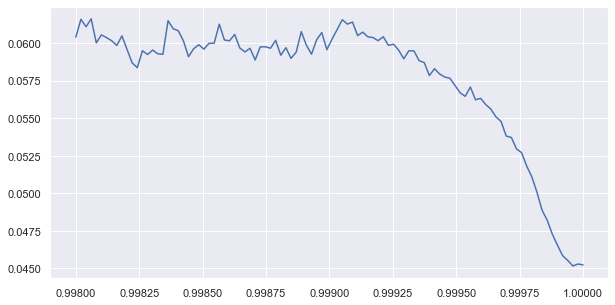

In [156]:
N = 100
lambdas = np.linspace(0.998,1,N)
cols = data_train.columns[idx2][:100]

errors = np.zeros(N)
for i in tqdm(range(N)):

    model3 = RandomForestRegressor(max_leaf_nodes=700,
                                verbose = False,
                                n_jobs=4,
                                n_estimators = 50,
                                max_features=100)
    model3.fit(data_train[cols], y_train, sample_weight=lambdas[i]**data_train.index[::-1])
    y_hat = model3.predict(data_val[cols])
    err = pow(y_hat-y_val, 2).mean()
    errors[i] = err

fig, ax = plt.subplots(figsize = (10,5))

ax.plot(lambdas, errors);



In [40]:
train = '2022-02-01'
df                      = pd.read_excel("data/Realized Schedule.xlsx")  # Load Train and validation data  
df_test                 = pd.read_excel("data/Future Schedule.xlsx")    # Load test data
y_val                   = df[df.ScheduleTime > train].LoadFactor
y_train                 = df[df.ScheduleTime <= train].LoadFactor
data                    = pd.concat([df[df.ScheduleTime <= train], df[df.ScheduleTime > train].drop("LoadFactor", axis = 1), df_test]).reset_index()
data["Hour"]            = data.ScheduleTime.dt.hour
data["Weekday"]         = data.ScheduleTime.dt.weekday

# # mean loadfactor for training data: will replace all missing values in the time series
# replacer_mu = data[data.ScheduleTime <= train].LoadFactor.mean() 

# # create time series variables that holds the loadfactor of the last destination/sector/airline
# new         = ['load_prev_destination','load_prev_sector', 'load_prev_airline']
# original    = ['Destination', 'Sector', 'Airline']

# for i, j in zip(new,original):  
#     data[i] = data.groupby(j)['LoadFactor'].shift()

# data = pd.get_dummies(data.drop(["FlightNumber","index"], axis = 1))  # Drop FlightNumber and AircraftType for simplicity
data = data.drop(["FlightNumber"], axis = 1)
data_train  = data[data.ScheduleTime <= train].drop(["LoadFactor", "ScheduleTime"], axis = 1)                                                   
data_val    = data[(data.ScheduleTime > train) * (data.ScheduleTime < '2022-03-01')].drop(["LoadFactor", "ScheduleTime"], axis = 1)  
data_test   = data[data.ScheduleTime >= '2022-03-01'].drop(["LoadFactor", "ScheduleTime"], axis = 1)  # March for test data

100%|██████████| 1000/1000 [10:19<00:00,  1.61it/s]


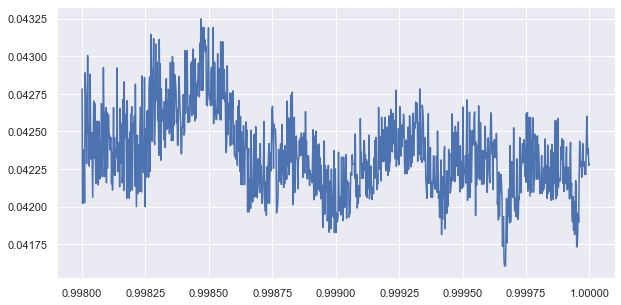

In [125]:
train = '2022-02-01'
df                      = pd.read_excel("data/Realized Schedule.xlsx")  # Load Train and validation data  
df_test                 = pd.read_excel("data/Future Schedule.xlsx")    # Load test data
y_val                   = df[df.ScheduleTime > train].LoadFactor
y_train                 = df[df.ScheduleTime <= train].LoadFactor
data                    = pd.concat([df[df.ScheduleTime <= train], df[df.ScheduleTime > train].drop("LoadFactor", axis = 1), df_test]).reset_index()
data["Hour"]            = data.ScheduleTime.dt.hour
data["Weekday"]         = data.ScheduleTime.dt.weekday

data = data.drop(["FlightNumber"], axis = 1)
data_train  = data[data.ScheduleTime <= train].drop(["LoadFactor", "ScheduleTime"], axis = 1)                                                   
data_val    = data[(data.ScheduleTime > train) * (data.ScheduleTime < '2022-03-01')].drop(["LoadFactor", "ScheduleTime"], axis = 1)  
data_test   = data[data.ScheduleTime >= '2022-03-01'].drop(["LoadFactor", "ScheduleTime"], axis = 1)  # March for test data


df = data_train.groupby(["Destination", "Airline"]).agg({'index': lambda x: [x]})
df['count'] = df['index'].apply(lambda x: np.arange(len(x[0]))[::-1])
index  = np.concatenate(df['index'].apply(lambda x: np.array(x[0])).values)
values = np.concatenate(df['count'].apply(lambda x: np.array(x)).values)
steps = values[index.argsort()]

data = pd.get_dummies(data.drop("index", axis = 1))
data_train  = data[data.ScheduleTime <= train].drop(["LoadFactor", "ScheduleTime"], axis = 1)                                                   
data_val    = data[(data.ScheduleTime > train) * (data.ScheduleTime < '2022-03-01')].drop(["LoadFactor", "ScheduleTime"], axis = 1)  
data_test   = data[data.ScheduleTime >= '2022-03-01'].drop(["LoadFactor", "ScheduleTime"], axis = 1)  # March for test data

N = 1000
lambdas = np.linspace(0.998,1,N)
cols = data_train.columns[idx2][:100]

errors = np.zeros(N)
for i in tqdm(range(N)):

    model3 = DecisionTreeRegressor(max_leaf_nodes=800)
    model3.fit(data_train[cols], y_train, sample_weight= lambdas[i]**steps)
    y_hat = model3.predict(data_val[cols])
    err = pow(y_hat-y_val, 2).mean()
    errors[i] = err

fig, ax = plt.subplots(figsize = (10,5))

ax.plot(lambdas, errors);

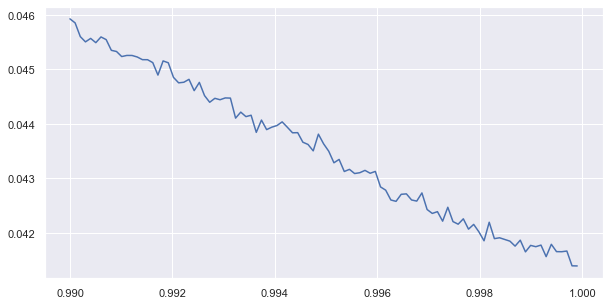

In [123]:
fig, ax = plt.subplots(figsize = (10,5))

ax.plot(lambdas[:-1], errors[:-1]);